In [1366]:
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import pylab,random
import matplotlib.pyplot as plt
from os import system
from scipy.cluster.hierarchy import fcluster,linkage,cophenet
from IPython.display import display, HTML

global familymatching_thresh
global enough_PE2barcode_numthresh 
global pe2readthresh 
global cellname_col 
global totalread_col 
global pe2read_col 
global barcodelist_col 
global barcodecnt_col 
global barcodenum_col 


familymatching_thresh = 0
enough_PE2barcode_numthresh = 5
pe2readthresh = 1
cellname_col = 0
totalread_col = 1
pe2read_col = 2
barcodelist_col = 3
barcodecnt_col = 4
barcodenum_col = 5

def indexing(seq,key,equal):
    ### Find the element in the list that matches a key
    if equal:
        return set([i for i in xrange(len(seq)) if seq[i]==key])
    else:
        return set([i for i in xrange(len(seq)) if seq[i]!=key])

def dist(seq1,seq2):
    ### Calculate the  Levenshtein distance distance of two string, considering 'N' as wildcard
    n1 = indexing(seq1,'N',False)
    n2 = indexing(seq2,'N',False)
    nindex = list(set.intersection(n1,n2))
    return sum([1 for x in nindex if seq1[x]!=seq2[x]])

def listdist(seqs1,seqs2,dist_thresh):
    ### If any element of seqs1 matches any element of seq2, we call it a match
    for idx1 in range(len(seqs1)):
        for idx2 in range(len(seqs2)):
            t_dist = dist(seqs1[idx1],seqs2[idx2])
            if t_dist <= dist_thresh:
                return 0
    return 1

def distplot(data,xaxis):
    plt.figure()
    x = pd.Series(data, name=xaxis)
    ax = sns.distplot(x);
    pylab.show() 
    
def regplot(data,xlab,ylab):
    plt.figure()
    d = pd.DataFrame(data,columns=[xlab,ylab])
    ax = sns.regplot(x=xlab,y=ylab,data=d)
    pylab.show()
    
def lmplot(data,d1,d2,hue,colors,annotate,labels,label_data):
    d = pd.DataFrame(data,columns=[d1,d2,hue])
    if  colors == '':
        sns.lmplot(d1,d2, data=d, hue=hue, fit_reg=False)
    else:
        sns.lmplot(d1,d2, data=d, hue=hue, fit_reg=False,palette=colors)  
   
    if annotate:
        for label, x, y in zip(labels, label_data[:, 0], label_data[:, 1]):
            plt.annotate(
                label,
                xy = (x, y), xytext = mycircle(20,random.uniform(1,360)),
                textcoords = 'offset points', ha = 'right', va = 'bottom',
                bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
                arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

    pylab.show()

def mycircle(radius,degree):
    return radius * np.sin(2*np.pi*degree/360), radius*np.cos(2*np.pi*degree/360)

In [1367]:
def family(withbarcode):
    num = len(withbarcode)
    alldist = np.zeros([num,num])
    for idx1 in range(num):
        for idx2 in range(num):
            alldist[idx1,idx2] = 0 if idx1 == idx2 \
            else listdist(withbarcode[idx1][barcodelist_col].split(','),withbarcode[idx2][barcodelist_col].split(','),familymatching_thresh)
    
    cond_dist = []
    for idx1 in range(num-1):
        for idx2 in range(idx1+1,num):
            cond_dist.append(alldist[idx1,idx2])
    
    link = linkage(cond_dist,method='single')
    cell2lineage = fcluster(link,0.5,criterion='distance')
    cell2lineage = [x-1 for x in cell2lineage]
    
    lineages = np.unique(cell2lineage)
    lineage2cell = [None]*len(lineages)
    for lineage in lineages: 
        lineage2cell[lineage] = [cell for cell in range(len(cell2lineage)) if cell2lineage[cell]==lineage]
    
    print '(Recap)Num of valid cell :',len(withbarcode)
    print 'Total num of barcode combo (family):',len(lineages)             
    print 'Num of invalid family with only one cell:', len([cells for cells in lineage2cell if len(cells)==1]) 
    
    validfamily = [lineage for lineage in lineages if len(lineage2cell[lineage])>1]
    validfamily_cellcnt = [len(lineage2cell[x]) for x in validfamily]
    print 'Num of valid family (with more than 1 cell):',len(validfamily)
    print 'Num of valid cells covered by valid family (with more than one cells):',sum(validfamily_cellcnt)
    print 'Median num of valid cells in a valid family:',np.median(validfamily_cellcnt)
    
    distplot([len(cells) for cells in lineage2cell],"Num of cell in each family")
    distplot([x for x in validfamily_cellcnt],"Num of cell in each VALID family")
    
    print '\nThe barcode-combo of all the cells in the biggest family:'
    largestfamily = lineage2cell[lineages[np.argmax(validfamily_cellcnt)]]
    largestfamily_barcode = [withbarcode[x][barcodelist_col] for x in largestfamily]
    print '(size:',len(largestfamily_barcode),')'
    print largestfamily_barcode
    
    target = []
    for x in largestfamily_barcode:
        target = target + x.split(',')
    target = list(set(target))
    
    cond_dist = []
    for i in range(len(target)-1):
        for j in range(i+1,len(target)):
            cond_dist.append(dist(target[i],target[j]))
    
    link = linkage(cond_dist,method='single')
    target2clst = fcluster(link,0.5,criterion='distance')
    print 'num of unique barcodes in this family (tolerance<=0bp):',len(np.unique(target2clst))
    
    target2clst = [x-1 for x in target2clst]

    clst2cell = {}
    for x in largestfamily_barcode:
        t_target = x.split(',')
        for y in t_target:
            if target2clst[target.index(y)] not in clst2cell.keys():
                clst2cell[target2clst[target.index(y)]] = [x]
            else:
                clst2cell[target2clst[target.index(y)]].append(x)
                
    print 'The distribution of the number of cells each unique barcode in this family map to:'
    distplot([len(clst2cell[x]) for x in clst2cell.keys()],"Num of cell that each unique barcode maps to")
    
    biggest_clst = np.argmax([len(clst2cell[x]) for x in clst2cell.keys()])
    print 'The most popular barcode in this family:',[target[x] for x in range(len(target)) if target2clst[x]==clst2cell.keys()[biggest_clst]]
    print 'The cells that have the most popular barcode in this family:',clst2cell[clst2cell.keys()[biggest_clst]]
    print 'its size:',len(clst2cell[clst2cell.keys()[biggest_clst]])
    return cell2lineage

In [1381]:
def analysis(mappingfile,filtering_metric,runlabel):
    
    ### Print the Indrop processing stats
    print '#### Printing Indrop preprocessing stats ###'
    with open(filtering_metric) as f:
        for x in f: print x
    print '#### END ###\n'
    
    ### Read the mapping result
    with open(mappingfile) as f:
        data = [x.strip().split() for x in f]

    ### Analysis on the num of raw reads with PE2 barcode    
    print '\n###### Analysis on the num of reads with PE2 barcode'
    print 'Total num of cell:',len(data)
    print 'Total num of raw PE2 barcode reads without filtering:',sum([int(x[pe2read_col]) for x in data])
    hasanybarcode = [x for x in data if int(x[barcodenum_col])>0]
    print 'Num of valid cell with any PE2 barcode:',len(hasanybarcode)
    enoughbarcode = [x for x in data if int(x[pe2read_col])>enough_PE2barcode_numthresh]
    print 'Num of valid cell with more than ' + str(enough_PE2barcode_numthresh) + ' reads with raw PE2 barcode:',len(enoughbarcode)
  
    d1 = [np.log10(int(x[pe2read_col])) if (int(x[pe2read_col]))>0 else -1 for x in data ]
    d2 = [np.log10(int(x[totalread_col])) for x in data ]
    distplot(d1,'# (log10) of raw PE2 reads')
    distplot(d2,'# (log10) of total number of reads')
    
    print 'Plotting the relationship between the num of total reads and num of pe2 reads'
    regplot([ [d2[x],d1[x]] for x in range(len(d1))],'totalread (log10)','pe2read(log10)')
    
    
    ### Analyze the distribution of the num of reads per barcode in each cell
    print '\n###### Analysis on barcode-reads relationship'
    print '\nWe sort the barcode in each cell by its # of PE2 reads\n'
    readcnt = [np.log10(max(map(int,x[barcodecnt_col].split(','))))for x in data if int(x[barcodenum_col])>=1]
    print 'The distribution of the number (log10) of reads of the #1 barcode in each cell'
    distplot(readcnt,'Read cnt')
    
    readcnt = [np.log10(np.sort(map(int,x[barcodecnt_col].split(','))))[-2]for x in data if int(x[barcodenum_col])>=2]
    print 'The distribution of the number (log10) of reads of the #2 barcode in each cell'
    distplot(readcnt,'Read cnt')
    
    readcnt = [np.log10(np.sort(map(int,x[barcodecnt_col].split(','))))[-3]for x in data if int(x[barcodenum_col])>=3]
    print 'The distribution of the number (log10) of reads of the #3 barcode in each cell'
    if len(readcnt)>0:
        distplot(readcnt,'Read cnt')
    
    print 'Now printing the information for all the cell who has >= one valid barcode:'
    
    ooo = []
    for x in data:
        if int(x[barcodenum_col]) >= 1:
            ooo.append(x)
    d = pd.DataFrame(ooo,columns=['cellname','total # of reads','total # of pe2 reads','the list of barcodes','# of reads for each barcode','# of barcode'])
    display(d)
    outfile = 'cell_w_valid_barcode_'+runlabel+'.txt'
    print 'Result is saved to ',outfile
    d.to_csv(outfile)
         
    ### Analyze the num of reads of each barcode group across cells
    print '\n###### We put all the barcode appeared at least once together and cluster them into groups(<=0bp)\n'
    pe2 = [x[barcodelist_col].split(',')for x in data if int(x[barcodenum_col])>=1]
    pe2_cnt = [map(int,x[barcodecnt_col].split(','))for x in data if int(x[barcodenum_col])>=1]
    uni_pe2 = []
    for x in pe2:
        uni_pe2 += x
    uni_pe2 = list(set(uni_pe2))
    cond_dist = []
    for idx1 in range(len(uni_pe2)-1):
        for idx2 in range(idx1+1,len(uni_pe2)):
            cond_dist.append(dist(uni_pe2[idx1],uni_pe2[idx2]))
    link = linkage(cond_dist,method='single')
    uni_pe2_2_group = fcluster(link,0.5,criterion='distance') 
    uni_pe2_2_group = [x-1 for x in uni_pe2_2_group]
    mapper = {}
    for idx in range(len(uni_pe2_2_group)):
        mapper[uni_pe2[idx]] = uni_pe2_2_group[idx]
    groups = np.unique(uni_pe2_2_group)
    print 'num of barcode groups across cell:',len(groups)
    group_cnt = [[] for x in groups]
    for idx1 in range(len(pe2)):
        for idx2 in range((len(pe2[idx1]))):
            group_cnt[mapper[pe2[idx1][idx2]]].append(pe2_cnt[idx1][idx2])
    
    print '\nNow printing the num of reads across cells for each barcode group'
    ooo = []
    for x in group_cnt:
        ooo.append(','.join(map(str,np.sort(x)[::-1])))
    d = pd.DataFrame(ooo,columns=['# of reads across cell'])
    display(d)
    outfile = 'num_reads_of_barcode_'+runlabel +'.txt'
    print 'Result is saved to ',outfile
    d.to_csv(outfile)
            
    ### Filter the barcode by # of PE2 reads
    rawdata = [x for x in data]
    print '\n###### Now we ingore all PE2 barcode which doesn\'t have more than '+str(pe2readthresh)+' reads \n'
    for idx in range(len(data)):
        if data[idx][barcodelist_col] == '/':
            continue
        t_barcode = data[idx][barcodelist_col].split(',')
        t_cnt = map(int,data[idx][barcodecnt_col].split(','))
        goodpick = [x for x in range(len(t_barcode)) if t_cnt[x] > pe2readthresh]
        if len(goodpick) == 0:
            data[idx][barcodelist_col] = '/'
            data[idx][barcodecnt_col] = '0'
            data[idx][barcodenum_col] = '0'
        else:
            data[idx][barcodelist_col] = ','.join([t_barcode[x] for x in goodpick])
            data[idx][barcodecnt_col] = ','.join(map(str,[t_cnt[x] for x in goodpick]))
            data[idx][barcodenum_col] =len(goodpick)
    
    ### Analysis on valid cell
    print '\n###### Analysis on the number of unique barcode'
    print '(Recap)Num of cell :',len(data)
    
    print '\nFor each cell, we cluster the PE2 reads (2bp tolerance),\n\
    align within each cluster and keep only the \n\
    valid cluster barcode (with <66% bp that is \'N\') \n'
    
    withbarcode = [x for x in data if int(x[barcodenum_col])>0] 
    print 'Num of (valid) cell with valid PE2 barcode:',len(withbarcode)

    print 'The distribution of raw PE2 reads in valid cell:'
    distplot([np.log10(int(x[pe2read_col])) for x in withbarcode],"num (log10) of reads with PE2 barcode")
   
    print 'Num of valid cell with 1 unique barcode:',len([x for x in withbarcode if int(x[barcodenum_col])==1])
    print 'Num of valid cell with 2 unique barcode:',len([x for x in withbarcode if int(x[barcodenum_col])==2])
    print 'Num of valid cell with more than 2 unique barcode:',len([x for x in withbarcode if int(x[barcodenum_col])>2])
    print 'The distribtution of unique barcode in valid cell:'
    distplot([int(x[barcodenum_col]) for x in withbarcode],"num of unique PE2 barcode")
    
    ### Family analysis
    print '\n###### Analysing family statistics of ALL cell with barcode'
    withbarcode_lineage = family(withbarcode)
    return [[withbarcode[idx],withbarcode_lineage[idx]]for idx in range(len(withbarcode))]

In [1417]:
from sklearn import decomposition,manifold,preprocessing,metrics
from sklearn.preprocessing import scale,normalize,StandardScaler

def znormalze(counts):
    normalized = normalize(counts, axis=1, norm='l1')
    normalized2 = StandardScaler().fit_transform(normalized)
    return normalized2

def permtest(l,n):
    X = np.asarray([[l[idx][0],l[idx][1]] for idx in range(len(l))])
    Y = np.asarray([l[idx][2] for idx in range(len(l))])
    ori_score = metrics.silhouette_score(X, Y, metric='euclidean')
    cnt = 0
    for i in range(n):
        random.shuffle(Y)
        t_score = metrics.silhouette_score(X, Y, metric='euclidean')
        if t_score > ori_score:
            cnt += 1
    return float(cnt) / n
def PCAanalysis(datafile,clsts):
    with open(datafile) as f:
        rawdata = [x.strip().split('\t') for x in f]
    header = rawdata[0]
    cells = header[4:]
    genes = [x[0] for x in rawdata[1:]]
    data = np.asarray([map(float,x[4:]) for x in rawdata[1:]]).transpose()
    print data.shape
    unique_family = np.unique([x[1] for x in clsts])
    lineage_num = len(unique_family)
    
    ## Whole data analysis
    data_norm = znormalze(data)
    cellmapper = {}
    for x in cells:
        cellmapper[x] = 'NA'
    
    for x in clsts:
        cellmapper[x[0][0]] = x[1]
    
    lineagemap = []
    toanno_idx = []
    toanno_label = []
    for idx in range(len(data_norm)):
        t_key = cellmapper[cells[idx]]
        if t_key!='NA':
            lineagemap.append(t_key)
            toanno_idx.append(idx)
            toanno_label.append(t_key)
        else:
            lineagemap.append('others')
    
    print len(toanno_idx)
    print '### PCA analasis ###'
    Y = decomposition.PCA(n_components=2).fit(data_norm).transform(data_norm)
    annotatelist = np.asarray([[Y[x][0],Y[x][1]] for x in toanno_idx])
    lmplot([[Y[idx][0],Y[idx][1],lineagemap[idx]]for idx in range(len(Y))],'d1','d2','lineage',sns.color_palette("hls", lineage_num),True,toanno_label,annotatelist)

    l = [ [annotatelist[idx][0],annotatelist[idx][1],toanno_label[idx]] for idx in range(len(toanno_label))]
    print 'Permutation test on Silhouette Coefficient: p=',permtest(l,1000)
    
    print '### t-SNE analasis ###'
    Y = manifold.TSNE(n_components=2, init='pca', random_state=0,perplexity=5).fit_transform(data_norm)
    annotatelist = np.asarray([[Y[x][0],Y[x][1]] for x in toanno_idx])
    lmplot([[Y[idx][0],Y[idx][1],lineagemap[idx]]for idx in range(len(Y))],'d1','d2','lineage',sns.color_palette("hls", lineage_num),True,toanno_label,annotatelist)
    
    print '### Isomap analasis ###'
    Y = manifold.Isomap(5, 2).fit_transform(data_norm)
    annotatelist = np.asarray([[Y[x][0],Y[x][1]] for x in toanno_idx])
    lmplot([[Y[idx][0],Y[idx][1],lineagemap[idx]]for idx in range(len(Y))],'d1','d2','lineage',sns.color_palette("hls", lineage_num),True,toanno_label,annotatelist)
    
    
    ## Keep only the ones in lineage
    #pick = [ cells.index(clsts[idx][0][0]) for idx in range(len(clsts))]
    #data = data[pick,]
    #print data.shape
    #data = preprocessing.scale(data,axis=1)
    #data = znormalze(data)
    
    ## PCA analysis
    print '### PCA analasis ###'
    Y = decomposition.PCA(n_components=2).fit(data_norm).transform(data_norm)
    for lineage in unique_family:
        if lineage == 'NA':
            continue
        t_data = [[Y[idx][0],Y[idx][1],lineage] if lineagemap[idx]==lineage else [Y[idx][0],Y[idx][1],'others']for idx in range(len(Y))]
        lmplot(t_data,'d1','d2','lineage',{lineage:"r", "others":"b"},False,'','')
    
    ## t-SNE analysis
    print '### t-SNE analasis ###'
    Y = manifold.TSNE(n_components=2, init='pca', random_state=0,perplexity=5).fit_transform(data_norm)
    for lineage in unique_family:
        if lineage == 'NA':
            continue
        t_data = [[Y[idx][0],Y[idx][1],lineage] if lineagemap[idx]==lineage else [Y[idx][0],Y[idx][1],'others']for idx in range(len(Y))]
        lmplot(t_data,'d1','d2','lineage',{lineage:"r", "others":"b"},False,'','')
    
    ## isomap analysis
    print '### isomap analasis ###'
    Y = manifold.Isomap(5, 2).fit_transform(data_norm)
    for lineage in unique_family:
        if lineage == 'NA':
            continue
        t_data = [[Y[idx][0],Y[idx][1],lineage] if lineagemap[idx]==lineage else [Y[idx][0],Y[idx][1],'others']for idx in range(len(Y))]
        lmplot(t_data,'d1','d2','lineage',{lineage:"r", "others":"b"},False,'','') 

#### Printing Indrop preprocessing stats ###
Rejected Reads: 37401945

Rejection Flags:

  BC1: 5303246

  BC2: 11264389

  No_W1: 12250319

  No_polyT: 2564185

  W1_in_R2: 6019806

Total Reads: 356413993

Valid Fraction: 0.8950603911895233

Valid Reads: 319012048

#### END ###


###### Analysis on the num of reads with PE2 barcode
Total num of cell: 992
Total num of raw PE2 barcode reads without filtering: 240681
Num of valid cell with any PE2 barcode: 528
Num of valid cell with more than 5 reads with raw PE2 barcode: 117


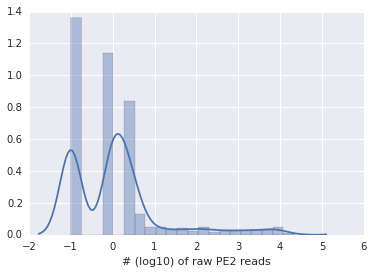

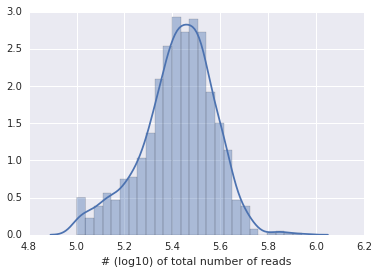

Plotting the relationship between the num of total reads and num of pe2 reads


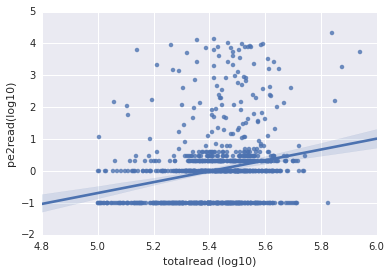


###### Analysis on barcode-reads relationship

We sort the barcode in each cell by its # of PE2 reads

The distribution of the number (log10) of reads of the #1 barcode in each cell


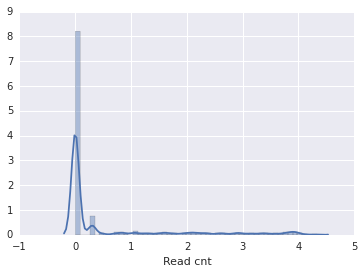

The distribution of the number (log10) of reads of the #2 barcode in each cell


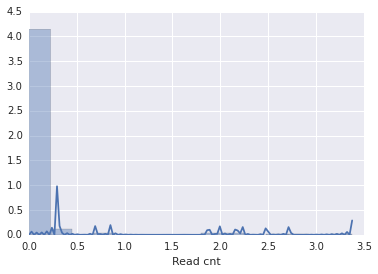

The distribution of the number (log10) of reads of the #3 barcode in each cell


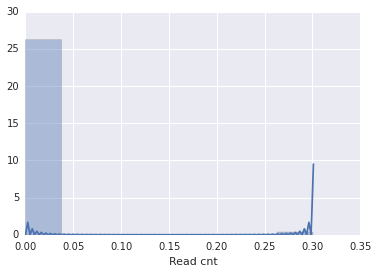

Now printing the information for all the cell who has >= one valid barcode:


,cellname,total # of reads,total # of pe2 reads,the list of barcodes,# of reads for each barcode,# of barcode
0,bc286,323886,1,TNGGNCCCNCGAANGGG,1,1
1,bc292,322966,2,"ATGGCTGTTTATTCTAG,ACGAAACTTGGTCGAGG","1,1",2
2,bc725,223421,2,GGTAACATGGGTGGTGT,1,1
3,bc573,257894,2,GTGATGGAGAGNNNGGT,1,1
4,bc902,159445,2,TGGGCTTCTTGTAGTCT,1,1
5,bc317,318446,2,GGATGCGTTCTTGGCGT,1,1
6,bc786,207179,1,GTTGGGTTGAGGCGGGG,1,1
7,bc091,407271,2,GNAGGNTTCGNCGANNG,1,1
8,bc054,427963,3,"GGTGGCCTAGCTGGGGC,AGGGATCGGATCGGTGN","1,1",2
9,bc268,329691,2,TGANNTNNAGCGCGGNG,1,1


Result is saved to  cell_w_valid_barcode_mESC.txt

###### We put all the barcode appeared at least once together and cluster them into groups(<=0bp)

num of barcode groups across cell: 131

Now printing the num of reads across cells for each barcode group


,# of reads across cell
0,"363,1"
1,"1377,1,1,1,1"
2,"9650,242,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1"
3,"135,1"
4,"3277,1,1"
5,"673,1,1,1"
6,"385,1"
7,"584,1"
8,"7730,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1"
9,"4051,225,5,2,2,1,1,1,1,1,1,1"


Result is saved to  num_reads_of_barcode_mESC.txt

###### Now we ingore all PE2 barcode which doesn't have more than 1 reads 


###### Analysis on the number of unique barcode
(Recap)Num of cell : 992

For each cell, we cluster the PE2 reads (2bp tolerance),
    align within each cluster and keep only the 
    valid cluster barcode (with <66% bp that is 'N') 

Num of (valid) cell with valid PE2 barcode: 153
The distribution of raw PE2 reads in valid cell:


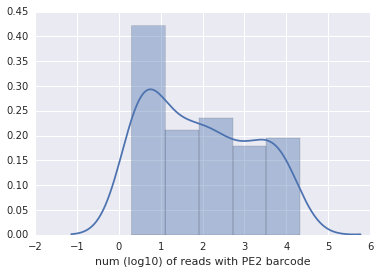

Num of valid cell with 1 unique barcode: 138
Num of valid cell with 2 unique barcode: 14
Num of valid cell with more than 2 unique barcode: 1
The distribtution of unique barcode in valid cell:


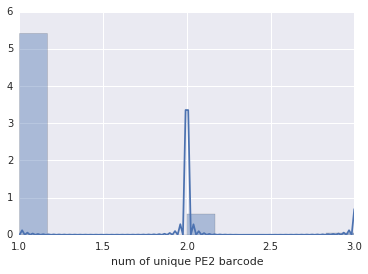


###### Analysing family statistics of ALL cell with barcode
(Recap)Num of valid cell : 153
Total num of barcode combo (family): 108
Num of invalid family with only one cell: 85
Num of valid family (with more than 1 cell): 23
Num of valid cells covered by valid family (with more than one cells): 68
Median num of valid cells in a valid family: 2.0


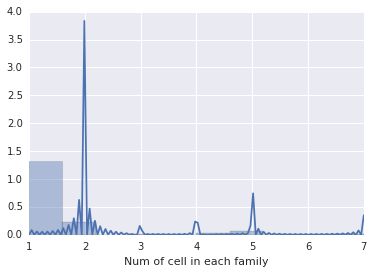

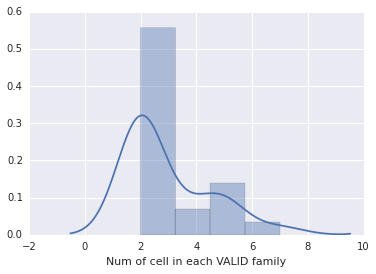


The barcode-combo of all the cells in the biggest family:
(size: 7 )
['AGGGATCGGATCGGNGT', 'GTGTAATTGTGTGGGTG', 'GTGTAATTGTGTGGGTG', 'GTGTAATTGTGTGGGTG', 'AGGGANCGGATCGNGCA', 'AGGGNTCGGATCGGNNN,GTGTAATTGTGTGGGTG', 'GTGTAATTGTGTGGGTG']
num of unique barcodes in this family (tolerance<=0bp): 2
The distribution of the number of cells each unique barcode in this family map to:


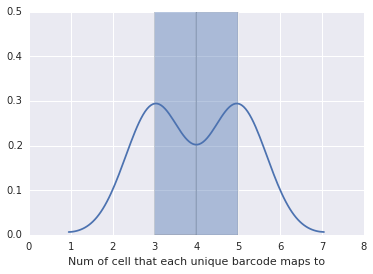

The most popular barcode in this family: ['GTGTAATTGTGTGGGTG']
The cells that have the most popular barcode in this family: ['GTGTAATTGTGTGGGTG', 'GTGTAATTGTGTGGGTG', 'GTGTAATTGTGTGGGTG', 'AGGGNTCGGATCGGNNN,GTGTAATTGTGTGGGTG', 'GTGTAATTGTGTGGGTG']
its size: 5


In [1418]:
mappingfile = '/cluster/zeng/research/lineage/mESC/post_split/cell-lineage_mapping_quality20_mismatch2_prefixsuffixtol2'
filtering_metric = '/cluster/zeng/research/lineage/mESC/stats/filtering_metrics.yaml'
lineage = analysis(mappingfile,filtering_metric,'mESC')

In [1419]:
all_family = [x[1] for x in lineage]
good_lineage = [x for x in lineage if all_family.count(x[1])>1]
a = [x[0][0] for x in lineage if x[1]==1]
b = [x for x in lineage if x[0][0] in a]
print a
for x in b:
    print x

['bc417', 'bc235', 'bc563', 'bc855', 'bc071']
[['bc417', '292146', '10173', 'ACCCAAAATAAGGGCGG,TTCTGTTCTGGATGATT,TGAGTTGAAGCGCGGTG', '9853,305,2', 3], 1]
[['bc235', '338463', '12', 'TGAGTTGAAGCGCGGTG', '8', 1], 1]
[['bc563', '260163', '48', 'TTCTGTTCTGGATGATT', '47', 1], 1]
[['bc855', '182589', '9003', 'TGAGTTGAAGCGCGGTG', '8953', 1], 1]
[['bc071', '417154', '2', 'TGAGTTGAAGCGCGGTG', '2', 1], 1]


(992, 28784)
68
### PCA analasis ###


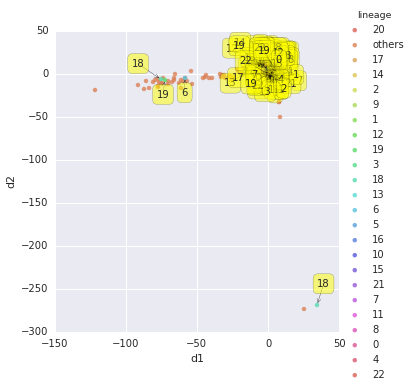

Permutation test on Silhouette Coefficient: p= 0.824
### t-SNE analasis ###


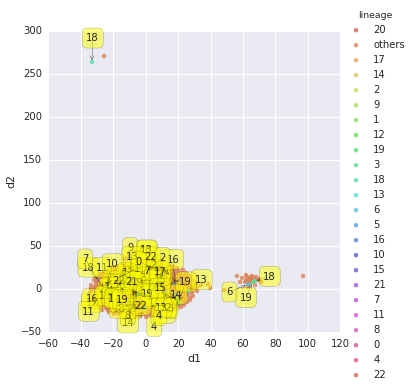

### Isomap analasis ###


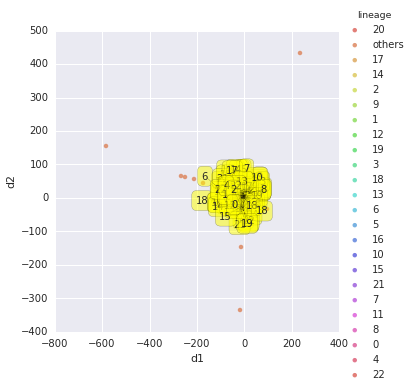

### PCA analasis ###


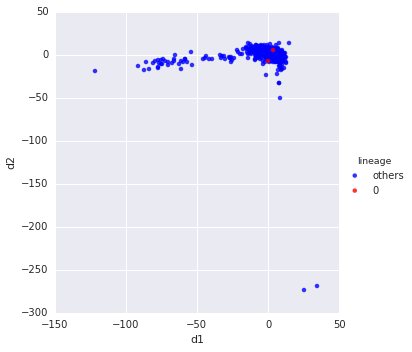

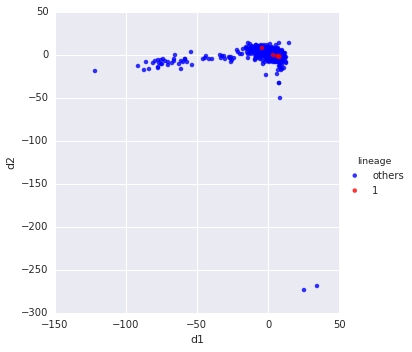

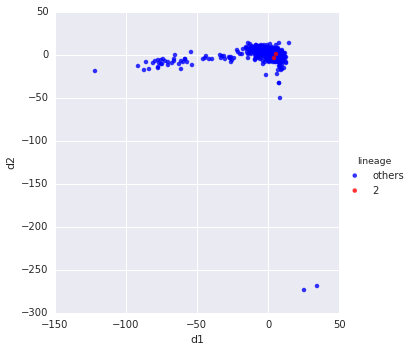

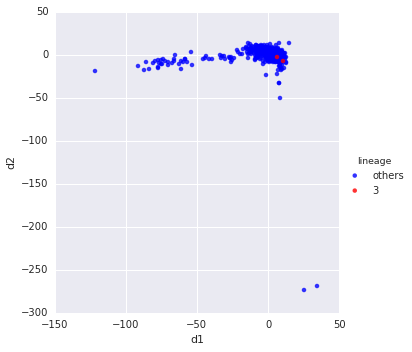

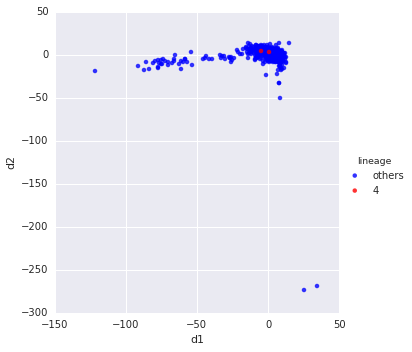

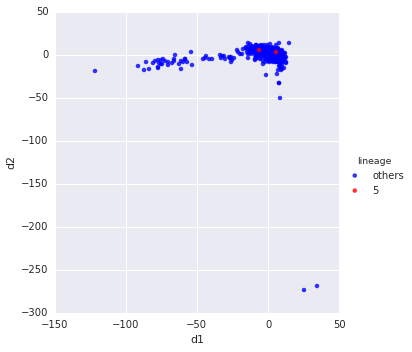

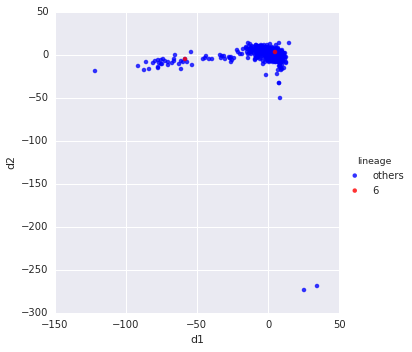

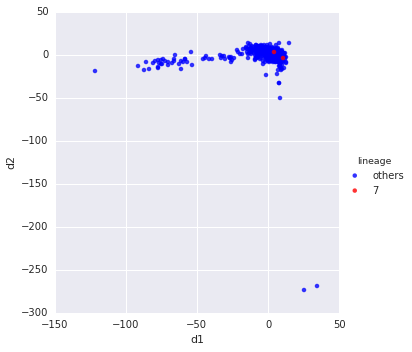

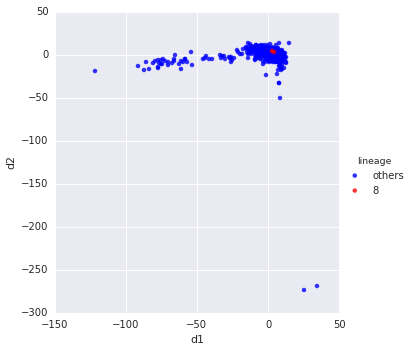

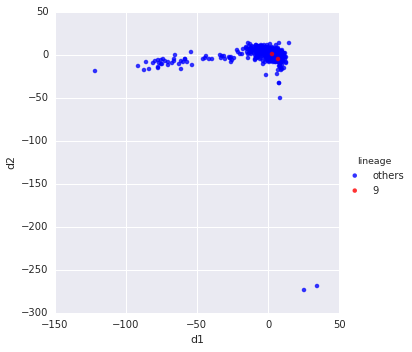

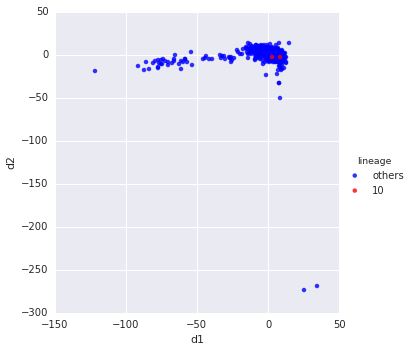

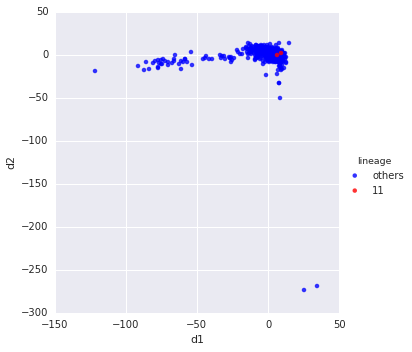

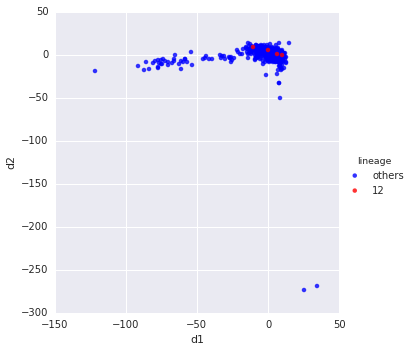

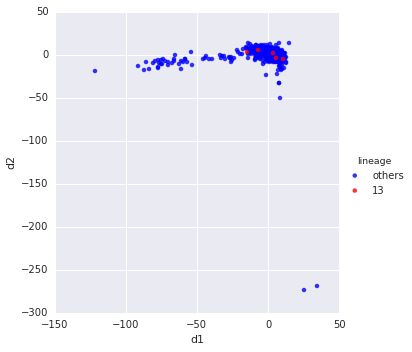

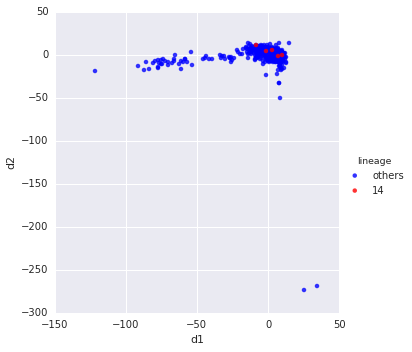

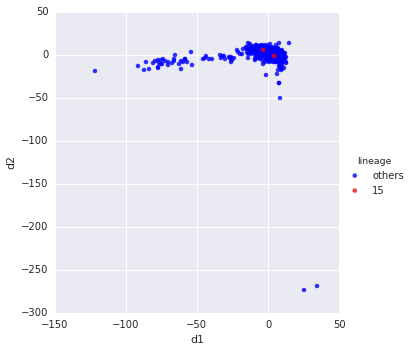

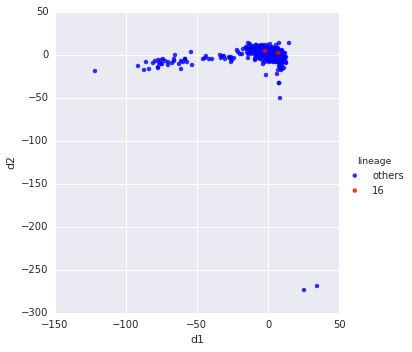

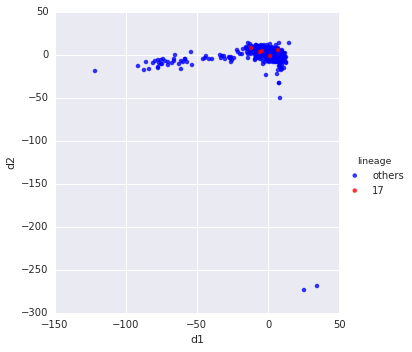

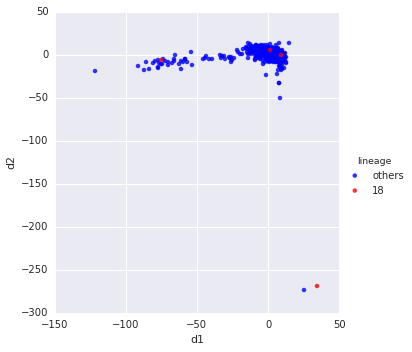

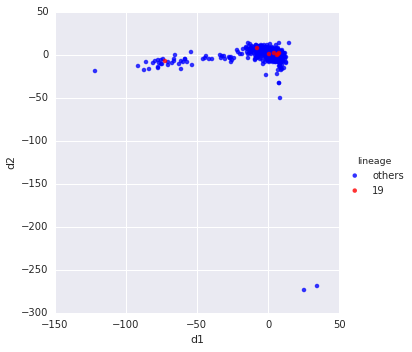

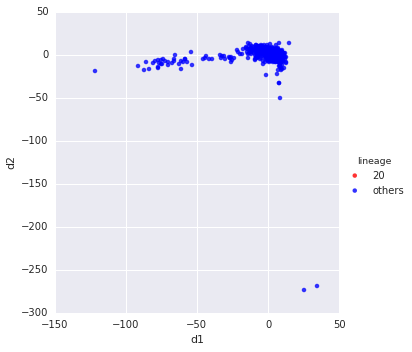

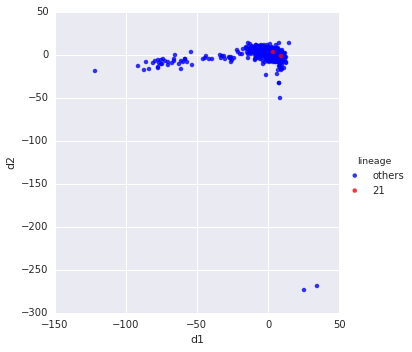

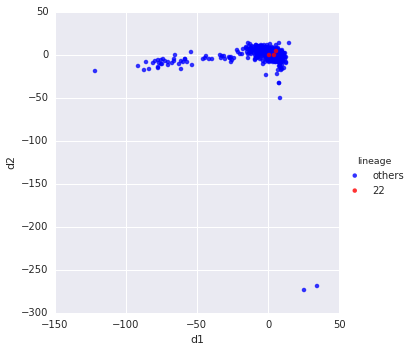

### t-SNE analasis ###


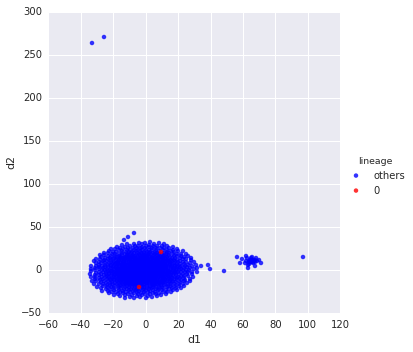

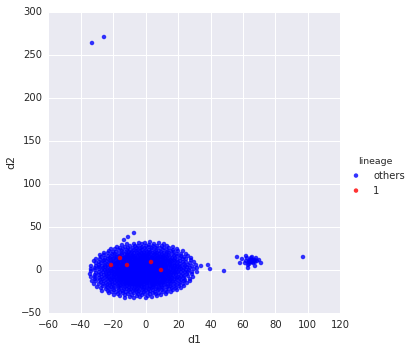

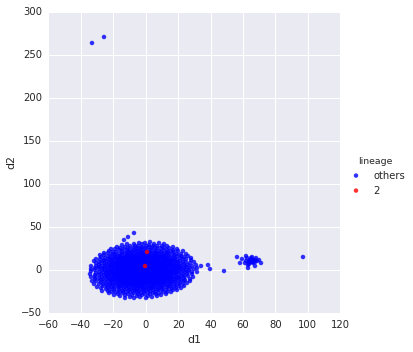

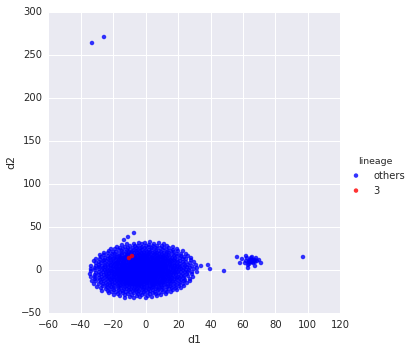

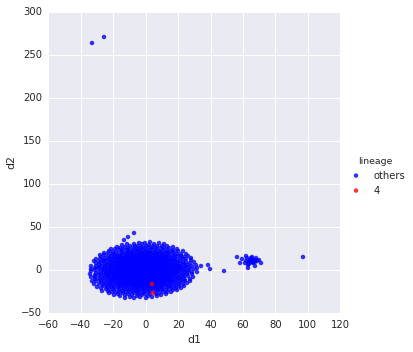

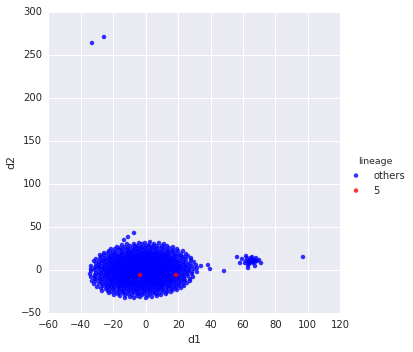

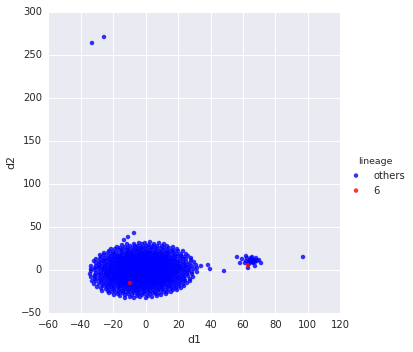

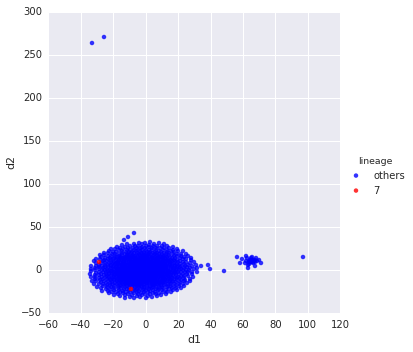

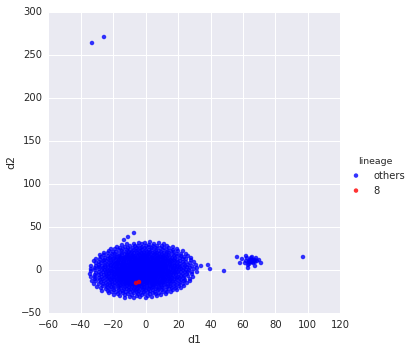

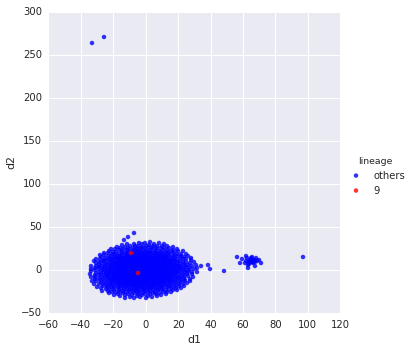

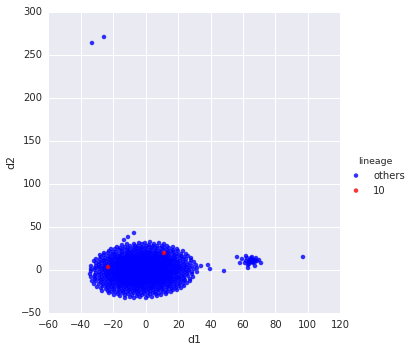

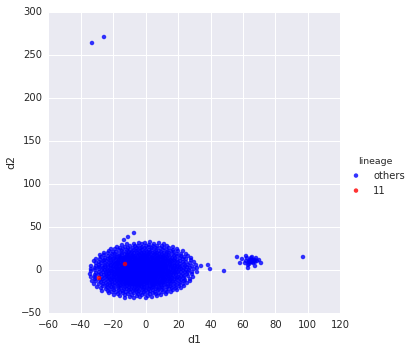

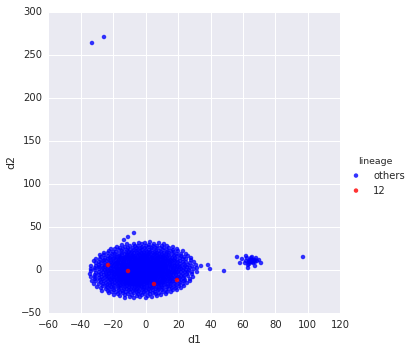

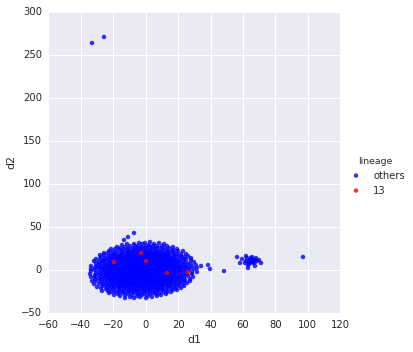

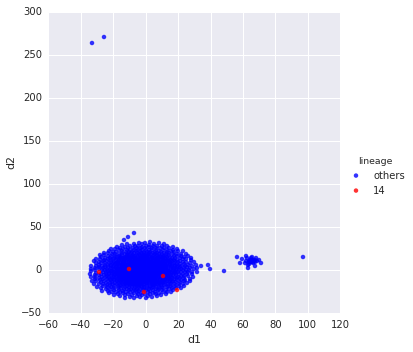

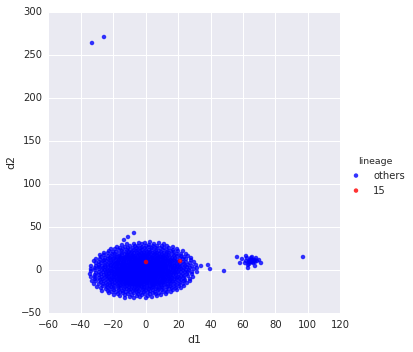

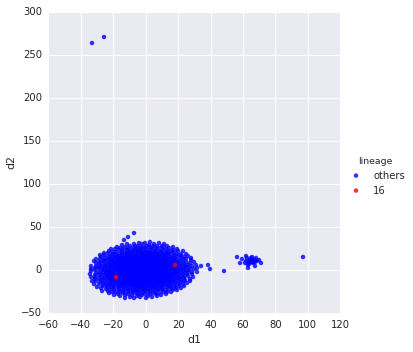

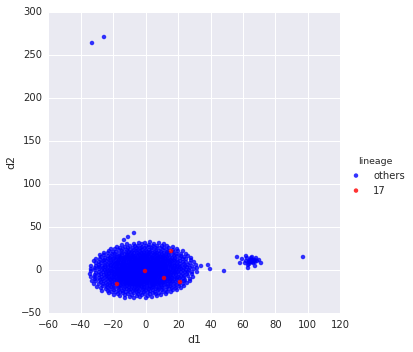

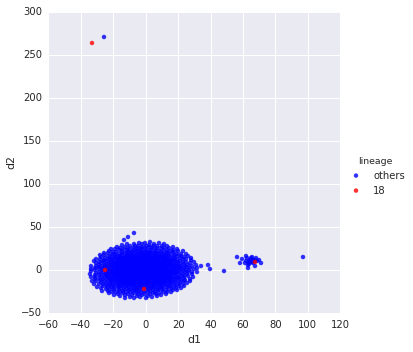

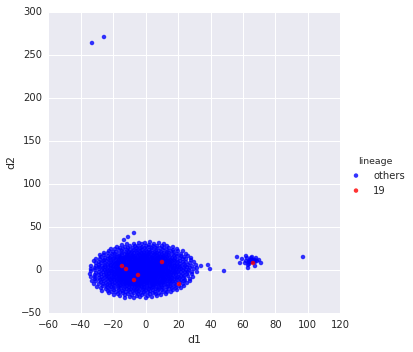

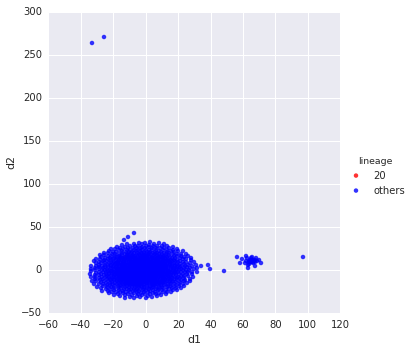

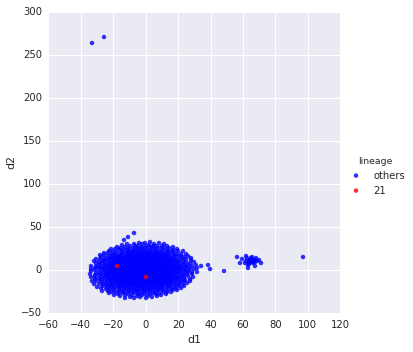

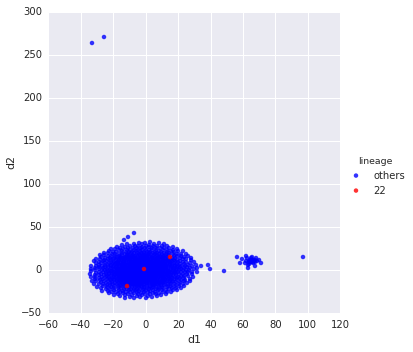

### isomap analasis ###


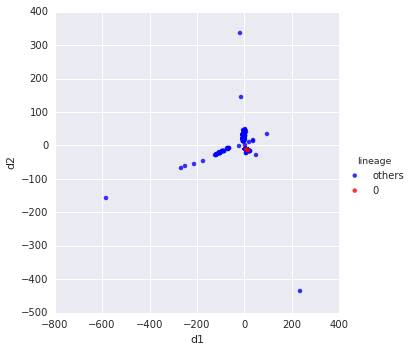

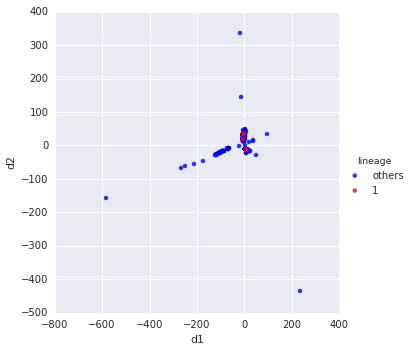

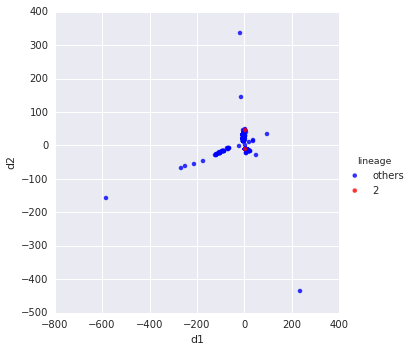

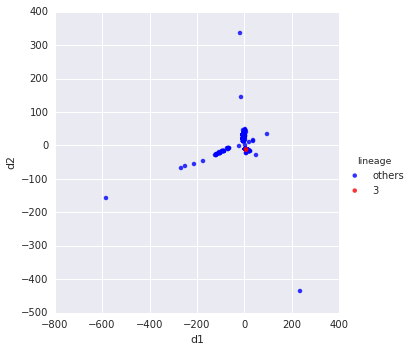

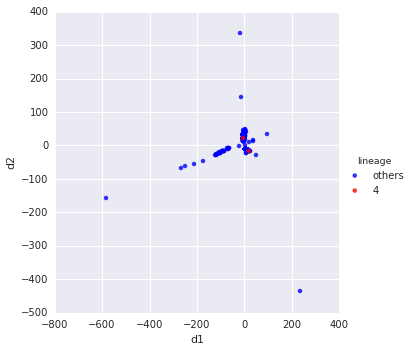

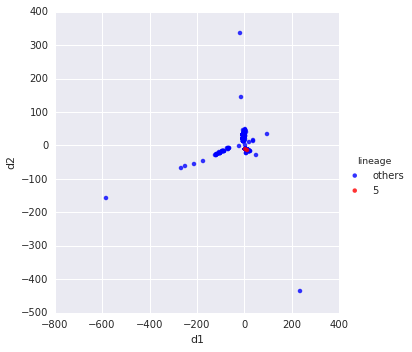

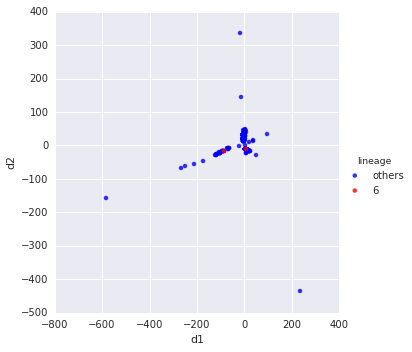

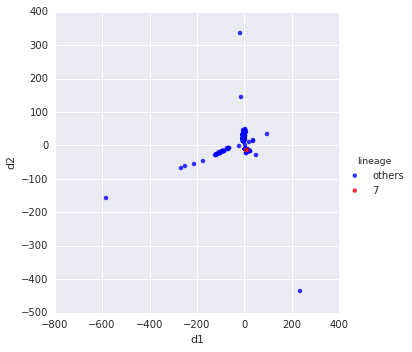

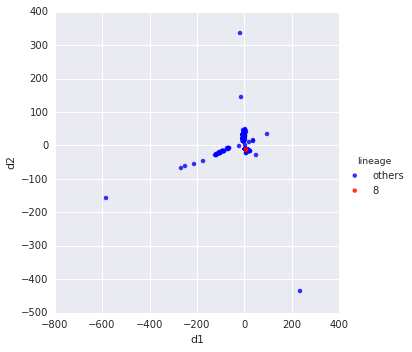

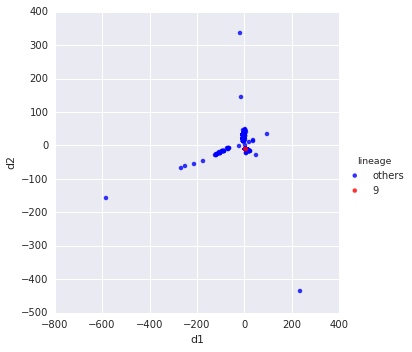

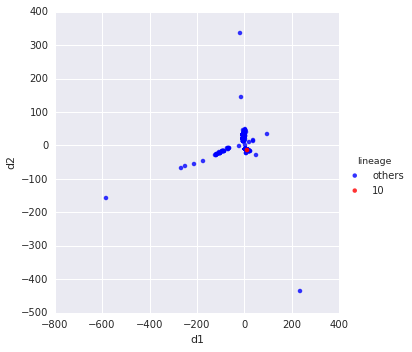

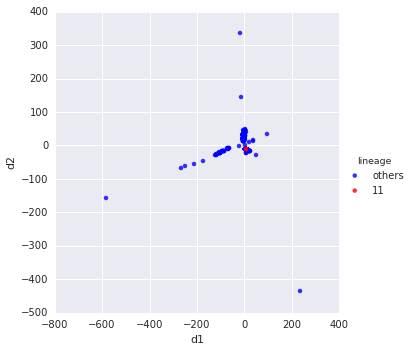

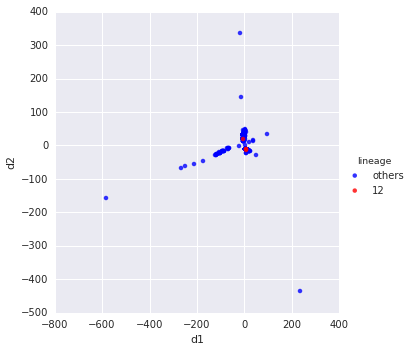

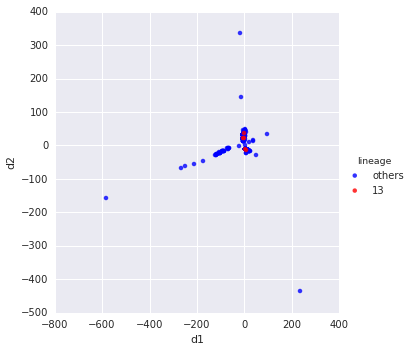

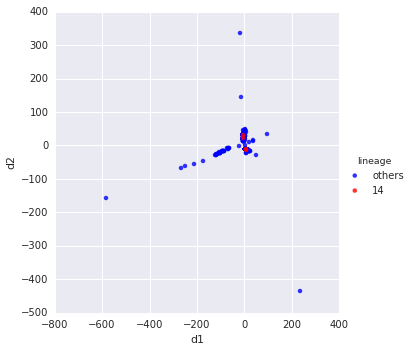

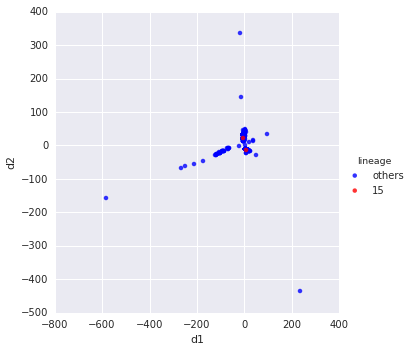

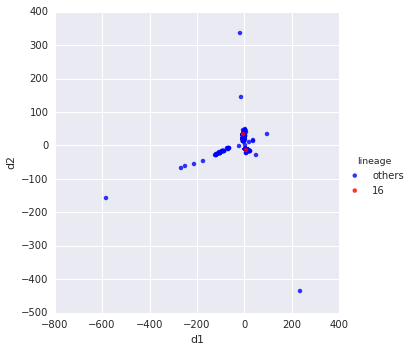

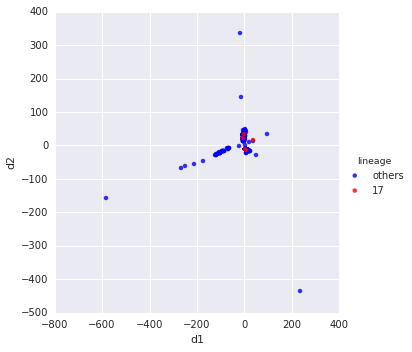

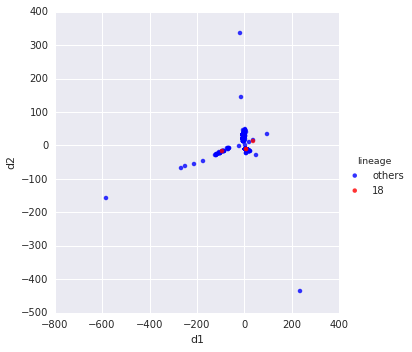

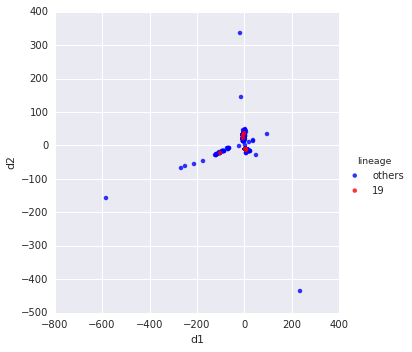

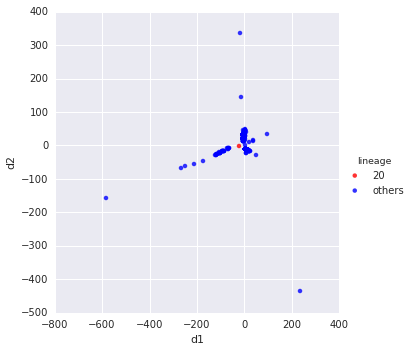

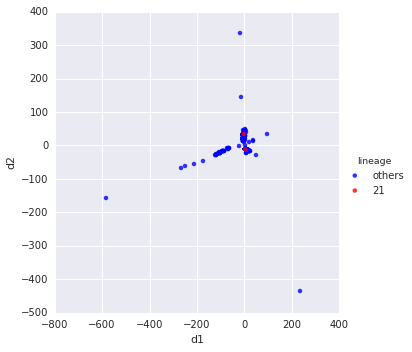

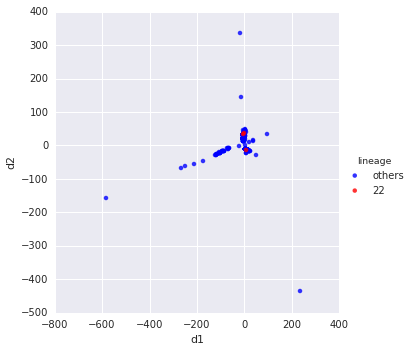

In [1420]:
all_family = [x[1] for x in lineage]
good_lineage = [x for x in lineage if all_family.count(x[1])>1]
PCAanalysis('/cluster/zeng/research/lineage/mESC/aggregated_counts/full_counts.txt',good_lineage)

#### Printing Indrop preprocessing stats ###
Rejected Reads: 37401945

Rejection Flags:

  BC1: 5303246

  BC2: 11264389

  No_W1: 12250319

  No_polyT: 2564185

  W1_in_R2: 6019806

Total Reads: 356413993

Valid Fraction: 0.8950603911895233

Valid Reads: 319012048

#### END ###


###### Analysis on the num of reads with PE2 barcode
Total num of cell: 874
Total num of raw PE2 barcode reads without filtering: 47794
Num of valid cell with any PE2 barcode: 143
Num of valid cell with more than 5 reads with raw PE2 barcode: 21


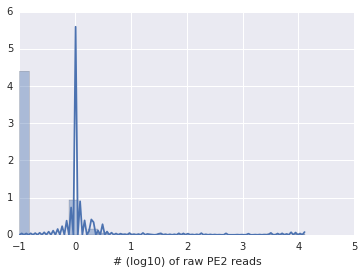

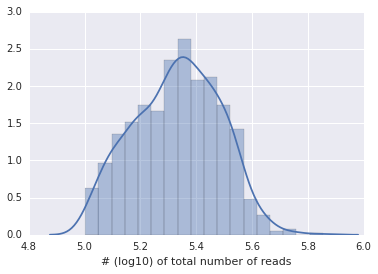

Plotting the relationship between the num of total reads and num of pe2 reads


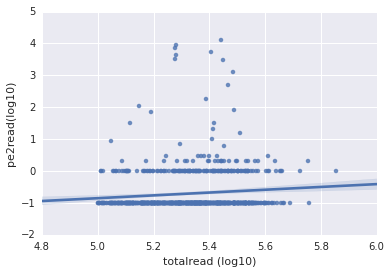


###### Analysis on barcode-reads relationship

We sort the barcode in each cell by its # of PE2 reads

The distribution of the number (log10) of reads of the #1 barcode in each cell


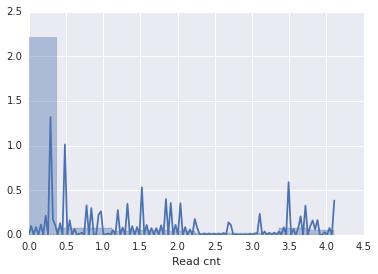

The distribution of the number (log10) of reads of the #2 barcode in each cell


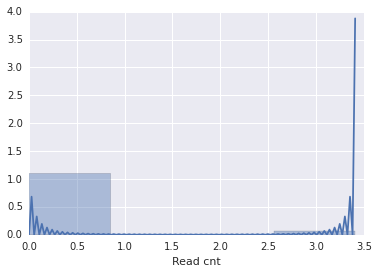

The distribution of the number (log10) of reads of the #3 barcode in each cell
Now printing the information for all the cell who has >= one valid barcode:


,cellname,total # of reads,total # of pe2 reads,the list of barcodes,# of reads for each barcode,# of barcode
0,bc868,102582,1,TGNCNTNTTGTANNNGG,1,1
1,bc254,269152,1,TGGGCTGCTGACACTTT,1,1
2,bc816,122014,1,GNGCAGACAAGNGGGGG,1,1
3,bc690,155156,70,GCTGAGGCAGAGTTAGG,70,1
4,bc273,262507,1,GAGGGAGTGGGGCTGGG,1,1
5,bc161,303171,1,TGTCTTTTTNTANNNNG,1,1
6,bc068,346536,1,TGGGNTGNTGACACTTT,1,1
7,bc576,186754,1,TGGGCTGNTGACACTTN,1,1
8,bc637,168016,1,TGGGCTGCTGACACTTT,1,1
9,bc609,176167,3,TGGGCTGCTGACACTTT,3,1


Result is saved to  cell_w_valid_barcode_endoderm.txt

###### We put all the barcode appeared at least once together and cluster them into groups(<=0bp)

num of barcode groups across cell: 14

Now printing the num of reads across cells for each barcode group


,# of reads across cell
0,"5256,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1"
1,"12763,2567,1245,176,21,16,6,3,2,2,2,1,1,1,1,1,..."
2,1
3,"3143,1,1,1,1,1,1,1,1,1,1"
4,"4376,3,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1"
5,"3088,32,1,1,1,1"
6,"33,1,1,1,1,1"
7,"7362,500,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1..."
8,"6383,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1"
9,"70,9,9"


Result is saved to  num_reads_of_barcode_endoderm.txt

###### Now we ingore all PE2 barcode which doesn't have more than 1 reads 


###### Analysis on the number of unique barcode
(Recap)Num of cell : 874

For each cell, we cluster the PE2 reads (2bp tolerance),
    align within each cluster and keep only the 
    valid cluster barcode (with <66% bp that is 'N') 

Num of (valid) cell with valid PE2 barcode: 31
The distribution of raw PE2 reads in valid cell:


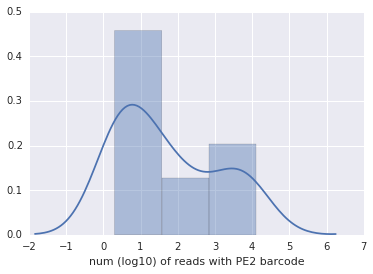

Num of valid cell with 1 unique barcode: 30
Num of valid cell with 2 unique barcode: 1
Num of valid cell with more than 2 unique barcode: 0
The distribtution of unique barcode in valid cell:


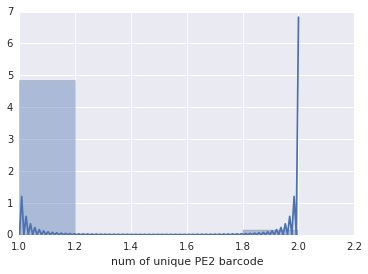


###### Analysing family statistics of ALL cell with barcode
(Recap)Num of valid cell : 31
Total num of barcode combo (family): 13
Num of invalid family with only one cell: 8
Num of valid family (with more than 1 cell): 5
Num of valid cells covered by valid family (with more than one cells): 23
Median num of valid cells in a valid family: 3.0


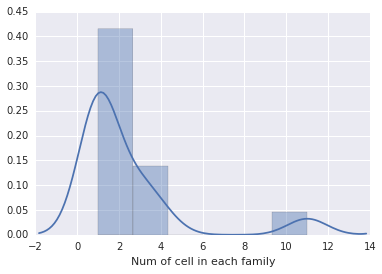

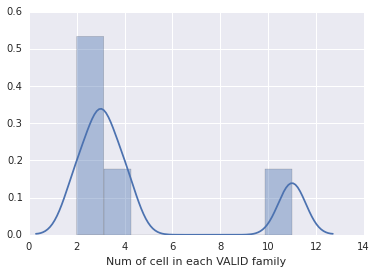


The barcode-combo of all the cells in the biggest family:
(size: 11 )
['TGGGCTGCTGACACTTT', 'TGGGCTGCTGACACTTT,GTGCAGACAAGAGGGGG', 'TGGGCTGCTGACACTTT', 'GTGCAGACAAGAGGGGG', 'TGGGCTGCTGACACTTT', 'TGGGCTGCTGACACTTT', 'TGGGCTGCTGACACTTT', 'TGGGCTGCTGACACTTT', 'TGGGCTGCTGACACTTT', 'TGGGCTGCTGACACTTT', 'TGGGCTGCTGACACTTT']
num of unique barcodes in this family (tolerance<=0bp): 2
The distribution of the number of cells each unique barcode in this family map to:


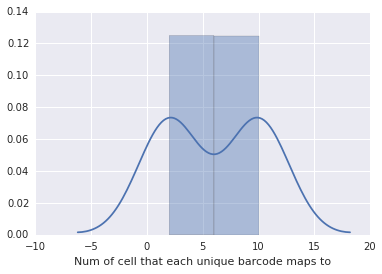

The most popular barcode in this family: ['TGGGCTGCTGACACTTT']
The cells that have the most popular barcode in this family: ['TGGGCTGCTGACACTTT', 'TGGGCTGCTGACACTTT,GTGCAGACAAGAGGGGG', 'TGGGCTGCTGACACTTT', 'TGGGCTGCTGACACTTT', 'TGGGCTGCTGACACTTT', 'TGGGCTGCTGACACTTT', 'TGGGCTGCTGACACTTT', 'TGGGCTGCTGACACTTT', 'TGGGCTGCTGACACTTT', 'TGGGCTGCTGACACTTT']
its size: 10


In [1421]:
mappingfile = '/cluster/zeng/research/lineage/endoderm/post_split/cell-lineage_mapping_quality20_mismatch2_prefixsuffixtol2'
filtering_metric = '/cluster/zeng/research/lineage/mESC/stats/filtering_metrics.yaml'
lineage = analysis(mappingfile,filtering_metric,'endoderm')

(874, 28784)
23
### PCA analasis ###


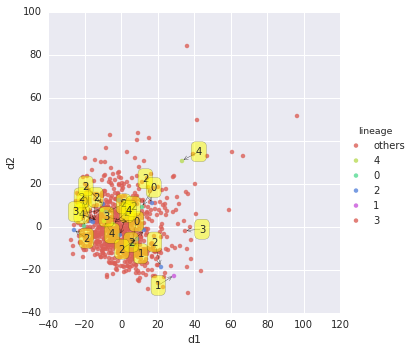

Permutation test on Silhouette Coefficient: p= 0.203
### t-SNE analasis ###


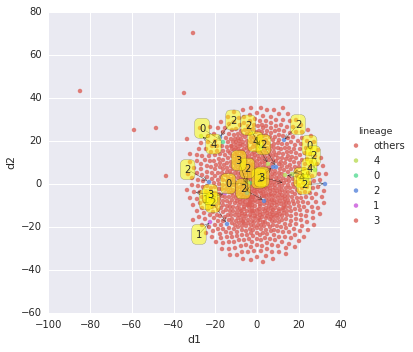

### Isomap analasis ###


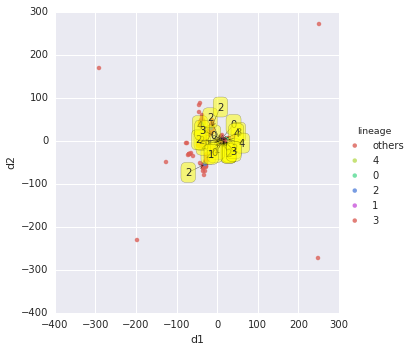

### PCA analasis ###


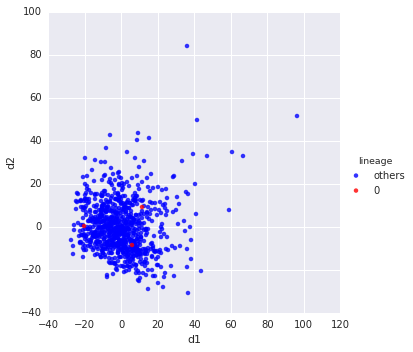

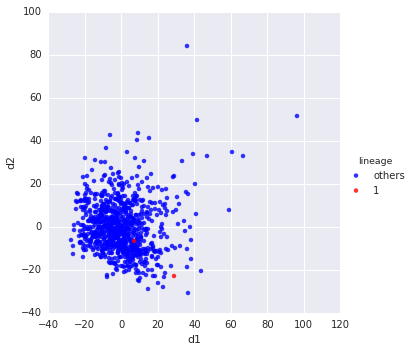

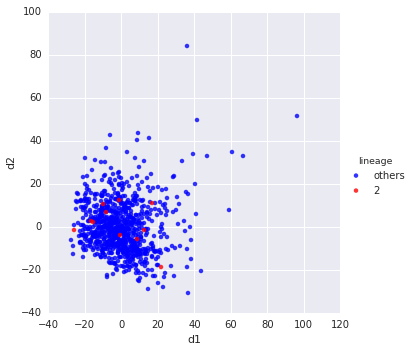

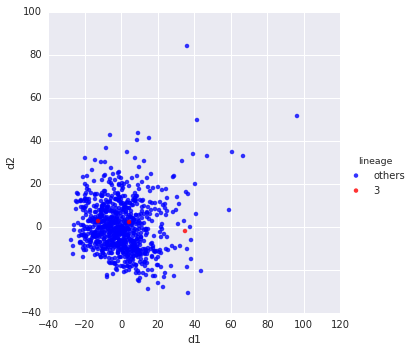

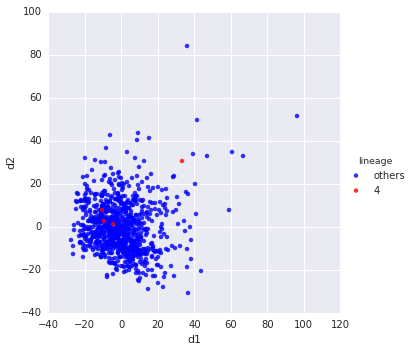

### t-SNE analasis ###


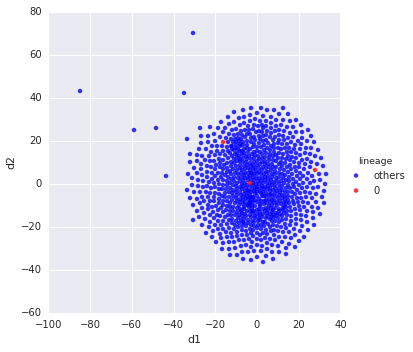

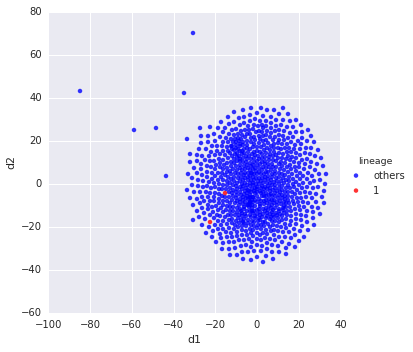

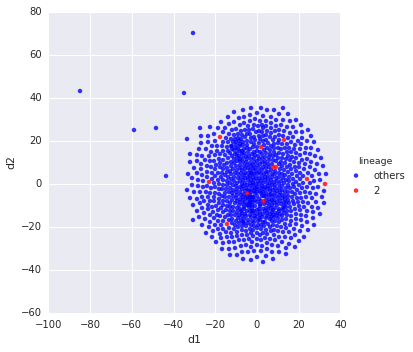

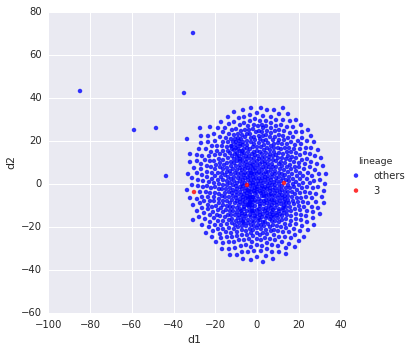

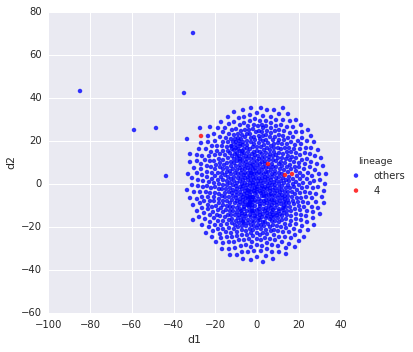

### isomap analasis ###


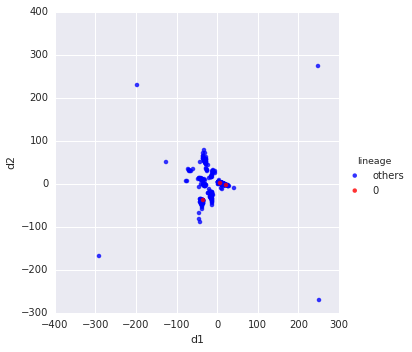

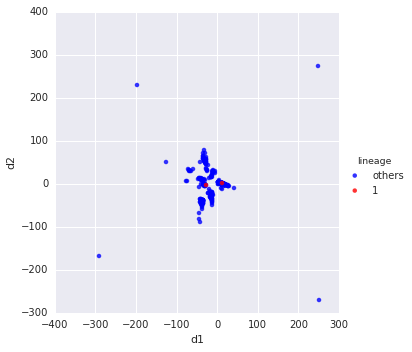

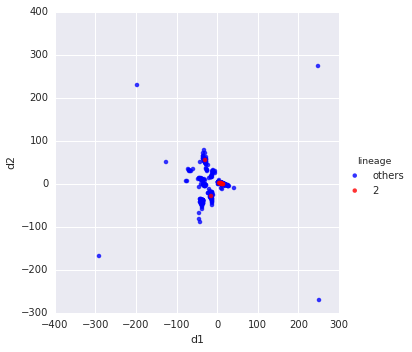

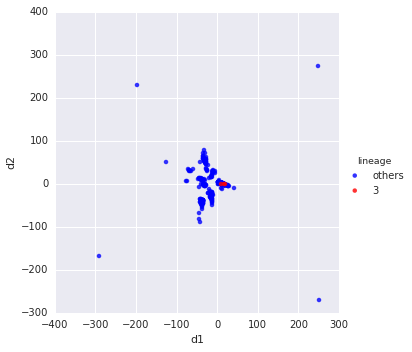

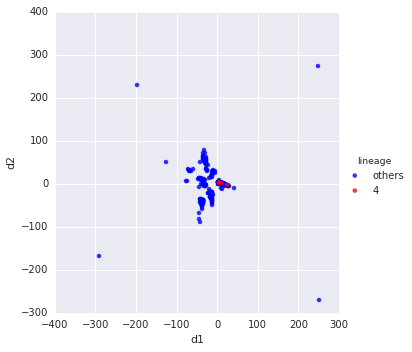

In [1422]:
all_family = [x[1] for x in lineage]
good_lineage = [x for x in lineage if all_family.count(x[1])>1]
PCAanalysis('/cluster/zeng/research/lineage/endoderm/aggregated_counts/full_counts.txt',good_lineage)

(1866, 28784)
### PCA analasis ###


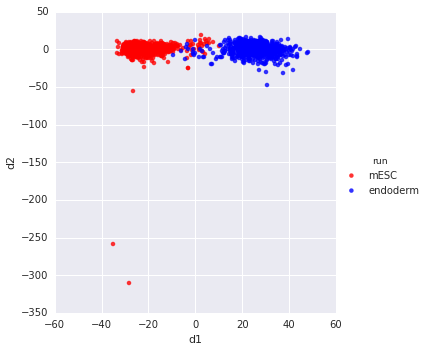

In [1249]:
with open('/cluster/zeng/research/lineage/endoderm/aggregated_counts/full_counts.txt') as f:
    f.readline()
    data2 = np.asarray([map(float,x.strip().split('\t')[4:]) for x in f]).transpose()
with open('/cluster/zeng/research/lineage/mESC/aggregated_counts/full_counts.txt') as f:
    f.readline()
    data1 = np.asarray([map(float,x.strip().split('\t')[4:]) for x in f]).transpose()

data = np.concatenate((data1,data2))
print data.shape
data = znormalze(data)

print '### PCA analasis ###'
Y = decomposition.PCA(n_components=2).fit(data).transform(data)
t_data = [[Y[idx][0],Y[idx][1],'mESC'] if idx<len(data1) else [Y[idx][0],Y[idx][1],'endoderm']for idx in range(len(Y))]
d = pd.DataFrame(t_data,columns=['d1','d2','run'])
colors = {'mESC':"r", 'endoderm':"b"}
sns.lmplot("d1", "d2", data=d, hue='run', fit_reg=False,palette=colors)
pylab.show()

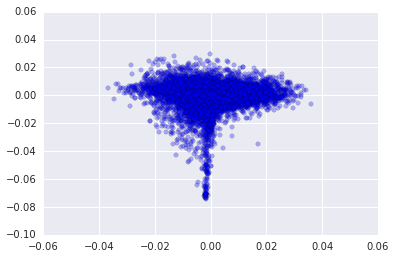

In [1267]:
q = decomposition.PCA(n_components=2).fit(data).components_
plt.scatter(*q, alpha=0.3, label="Loadings");
